# Neural Networks in biodiversity research
In this tutorial we will cover some **computational and data processing tools** that will come in handy when working with **neural network models**. This tutorial is focused on examples from biodiversity research, but many of the tools we're covering here are of general utility and will aid you also in other research fields.

## Installing tensorflow
We will be using the tensorflow Python library, which contains many handy machine learning functions. In case you don't have tensorflow installed on your computer yet, you can install it with `pip install Tensorflow`. If that does not work, you can use the conda installation manager instead. Follow the two steps below to get conda set up.

1. Install [miniconda](https://docs.conda.io/en/latest/miniconda.html). This is an installation manager that allows you easy installation of different programs. We will need this to compile the tensorflow library. I recommend you install the latest Python version of miniconda.

2. Once miniconda is installed there will be a new Python installation available on your computer in the standard path. That means you may need to reinstall some of the standard packages, such as numpy, scipy, etc. You can do this using either pip or conda. I recommend you use pip for most packages, except for Tensorflow. Install Tensorflow with `conda install tensorflow`.

If everything worked fine, you should now be able to load tensorflow **in Python** as follows:

In [1]:
import tensorflow as tf

Below is a list of packages we will be using during this exercise. Make sure all of these are installed. Except for tensorflow (see above), you can load all other packages using `pip`, e.g., `pip install numpy`. Once you have installed all of them, load the packages by executing the `import` commands below.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## Predicting species diversity

### Loading the data
Now we will use a dataset of features to predict the species diversity at different sites. The data is compiled for different sites from Australia, where we have information about the plant species diversity.

In [3]:
tbl = pd.read_csv("/Users/tobiasandermann/Documents/teaching/ai_course_geosciences/biodiv_exercise/data/div_data_all_features.txt", delimiter="\t")
tbl.head()

,species_div,n_occs,n_species,lon,lat,elevation,hfp,bio_1,bio_2,bio_3,...,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,avgdist
0,497.0,8.0,8.0,14552408.0,-3070888.0,373.0,5.2002,20.0292,14.5417,54.2599,...,13.7667,656.0,91.0,23.0,48.1925,270.0,78.0,270.0,78.0,43797.771873
1,397.0,214.0,149.0,13614735.0,-2218413.0,3.0,8.8415,27.2250,11.6167,55.0553,...,22.7333,887.0,240.0,1.0,124.4285,632.0,7.0,434.0,10.0,41928.482348
2,388.0,101.0,70.0,13589851.0,-2194423.0,3.0,7.8711,26.7333,11.4000,54.0284,...,22.1333,883.0,253.0,2.0,127.4999,638.0,8.0,422.0,15.0,53334.389178
3,471.0,7.0,7.0,13867423.0,-2514331.0,455.0,3.2500,23.8792,14.0250,54.1506,...,17.9333,550.0,129.0,6.0,96.8088,339.0,20.0,339.0,24.0,76127.736470
4,470.0,33.0,28.0,14482099.0,-2935228.0,109.0,15.6030,22.3083,12.7000,52.9167,...,16.6167,701.0,116.0,25.0,56.8911,316.0,77.0,316.0,77.0,64709.913499


You can see the first column (`species_div`) shows the species diversity. These are our labels that we will use to train the model. These diversity estimates were compiled for sites of different sizes. The size of these sites is specified in the last column, labeled `avgdist`, which marks the radius of the circle for which these estimates were made. The `n_occs`, and `n_species` columns show the number of GBIF occurrences and species identified through GBIF at this site. This is not the data that was used for the diversity estimates in the `species_div` column, which was compiled manually through species inventories, but instead these columns are meant to serve as a general measure of sampling density of the area. The other columns represent data associated with the center point of each site, such as longitude, latidue, elevation, human footprint, and a range of climatic estimates. You can find more information about these data [here](https://doi.org/10.1101/2022.01.12.475997).

All of these data will serve as features for our model, except for the first column `species_div`, which contains our labels. So let's first define feature and label data

In [4]:

features = tbl.values[:,1:]
feature_names = tbl.columns[1:]
labels = tbl.values[:,0]


To get an idea of the range of species diversities present in our data we can plot a histogram of these values:

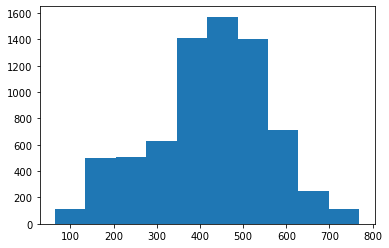

In [5]:
plt.hist(labels)
plt.show()

In the next steps we will build a Neural Network regression model to be able to predict species diversity based on our defined features. Once trained we will therefore be able to predict species diversity for any site for which we can compile these features. Given that the features are all based on spatial rasters that cover the whole globe, this means that it will work in theory for any given point in space. However, a model trained based on data from mostly Eastern Australia can't be meaningfully applied to predict diversity in e.g. North America. We will explore this a little by quantifying the prediction uncertainty of the model.

While the values that can be used to train an NN regression model can theoretically take any range, it generally helps the model to converge when rescaling these values to a smaller range, approximately ranging between 0 to 1. Below is a function that you can use to rescale any given 2D array. Rescaling is applied individually to each column and the output of the function is the rescaled array, as well as the original min-values and max-values of each column. These min and max arrays are needed to convert the data back to normal if desired, but this is not needed in this example. This scaling method is called min-max scaling and is also implemented in the sklearn machine learning library, which you may have used earlier in the course.

In [6]:
# This is a function that let's you rescale your data array. It rescales all values in each column to a range between 0 and 1.
def min_max_scaler(x, min_array=None, max_array=None, inverse_scale=False):
    if inverse_scale:
        x_new = x*(max_array-min_array)+min_array
        return(x_new)
    else:
        min_array = np.min(x,axis=0)
        max_array = np.max(x,axis=0)
        x_new = (x - min_array)/(max_array - min_array)
        return(x_new,min_array,max_array)

Now let's apply this function to our 2D feature array:

In [7]:
# Rescale features
rescaled_features, scale_min, scale_max = min_max_scaler(features)

# This is how you would transform the array back to normal
#min_max_scaler(rescaled_features, scale_min, scale_max, inverse_scale=True)


For our labels we'll apply a different scaling mechanism. For simplicity, we simply divide them by 800, which is close to value of the largest species diversity value in the dataset, leading approximately to a range between 0 and 1. This means that we need to multiply any diversity prediction made by our model by the factor 800 to get the real diversity estimate.

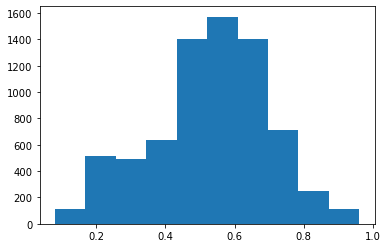

In [8]:
rescaled_labels = labels/800
plt.hist(rescaled_labels)
plt.show()

Next we want to select training, validation, and test set. Here is a custom function that does that and which also shuffles the instances. The function outputs arrays with the indices of the selected training, validation, and test instances.

In [9]:
def select_train_val_test(x,val_fraction=0.2,test_fraction=0.2,shuffle=True,seed=None):
    all_indices = np.arange(len(x))
    if shuffle:
        if not seed:
            seed = np.random.randint(0,999999999)
        # shuffle all input data and labels
        np.random.seed(seed)
        print('Shuffling data, using seed', seed)
        shuffled_indices = np.random.choice(all_indices, len(all_indices), replace=False)
    else:
        shuffled_indices = all_indices
    # select train, validation, and test data
    n_test_instances = np.round(len(shuffled_indices) * test_fraction).astype(int)
    n_validation_instances = np.round(len(shuffled_indices) * val_fraction).astype(int)
    test_ids = shuffled_indices[:n_test_instances]
    validation_ids = shuffled_indices[n_test_instances:n_test_instances + n_validation_instances]
    train_ids = shuffled_indices[n_test_instances + n_validation_instances:]
    return train_ids, validation_ids, test_ids


Now we run the function and apply the selected indices to our data.

In [10]:
# Separate instances into train and test set
train_set_ids, validation_set_ids, test_set_ids =  select_train_val_test(rescaled_features)
train_features = rescaled_features[train_set_ids]
train_labels = rescaled_labels[train_set_ids]
validation_features = rescaled_features[validation_set_ids]
validation_labels = rescaled_labels[validation_set_ids]
test_features = rescaled_features[test_set_ids]
test_labels = rescaled_labels[test_set_ids]


Shuffling data, using seed 371010543


### Defining a model
Now let's build the tensorflow model. This is essentially the same structure that we discussed in the lecture slides, except that we are using some more nodes and one extra hidden layer. Feel free to play around with the number of nodes and the number of layers. The loss function we are using is specified as `'mae'` which stands for "mean absolute error".

In [11]:
architecture = []

# Input layer
architecture.append(tf.keras.layers.Flatten(input_shape=[train_features.shape[1]]))
# 1st hidden layer
architecture.append(tf.keras.layers.Dense(32, activation='relu'))
# 2nd hidden layer
architecture.append(tf.keras.layers.Dense(8, activation='relu'))
# Output layer
architecture.append(tf.keras.layers.Dense(1, activation='softplus'))  # sigmoid or tanh or softplus

# Compile the model
model = tf.keras.Sequential(architecture)
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Get overview of model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 26)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                864       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
_________________________________________________________________


2022-02-09 09:28:12.787504: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


At this point the model is not yet trained with our training data, i.e. the weights are not at all optimized yet. But for demonstration purposes we can use it already to make predictions for our data, even if these are completely random at this point. For now let us make predictions for our test data, and compare later on how much better the trained model predicts them. You can predict with a defined model using `model.predict`:

In [12]:
estimated_test_labels = model.predict(test_features)

2022-02-09 09:28:12.865310: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


For regression tasks, a common data exploration tool is to plot the estimated labels against the true labels. This will given an idea how well the model is doing with the prediction task. Here is a simple plotting function to create this type of plot:

In [13]:
def plot_true_vs_pred(true_labels, predicted_labels):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(true_labels, predicted_labels, 'o', markersize=3, alpha=1)
    plt.plot([0,800],[0,800],'r-')
    plt.grid()
    plt.xlabel('True diversity')
    plt.ylabel('Predicted diversity')


Now we run this function on our predicted labels for the test set, after converting these back to the original scale by multiplying with the factor 800 (our rescaling factor that we used for transforming the biodiversity labels at the beginnig).

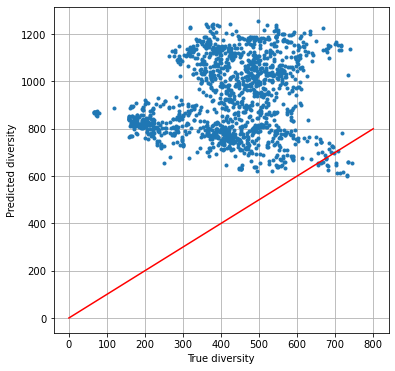

In [14]:
plot_true_vs_pred(test_labels*800,estimated_test_labels*800)

As expected, our untrained model is not doing a good job in predicting. In a case of well predicted labels the points in this scatter point would be located around the center diagonal.

### Training the model

It is now time to fit our model to the training data (= train our model), using `model.fit`. The number of epochs defines for how many epochs your model is training (optimizing the weights). Early stopping is a handy setting, that stops the training if the validation accuracy does not improve for N consecutive epochs. N can be set using the patience parameter. We specify that we will be monitoring `val_mae`, which stands for the mean absolute error for the validation set. Whenever you use early stopping, make sure you set the `restore_best_weights` setting to True, otherwise it will keep the weights of the last epoch, instead of the best epoch.

In [ ]:
# Define early stop of training based on validation set
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=200,restore_best_weights=True)
# Run model training and store training history
history = model.fit(train_features,
                          train_labels,
                          epochs=3000,
                          validation_data=(validation_features, validation_labels),
                          verbose=1,
                          callbacks=[early_stop],
                          batch_size=40)

Here is a plotting function that allows us to plot the history of the model training more conveniently. The plot will show the best identified method by the early stopping setting, which is marked with a dashed grey line. This is the epoch for which the model exported the weights.

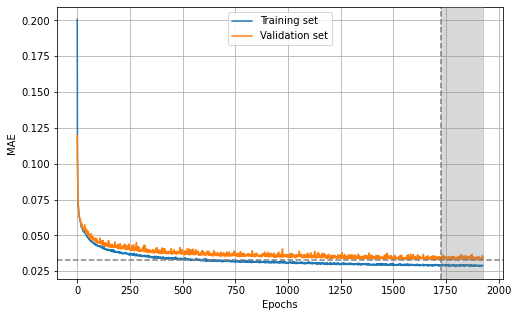

In [16]:
def plot_training_history(history, show_best_epoch=True):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(history.history['mae'], label='Training set')
    plt.plot(history.history['val_mae'], label='Validation set')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    if show_best_epoch:
        best_epoch = np.where(history.history['val_mae'] == np.min(history.history['val_mae']))[0][0]
        plt.axvline(best_epoch, c='grey', linestyle='--')
        plt.axhline(history.history['val_mae'][best_epoch], c='grey', linestyle='--')
        plt.gca().axvspan(best_epoch, len(history.history['mae']), color='grey', alpha=0.3, zorder=3)
    plt.grid()
    plt.legend(loc='upper center')

plot_training_history(history)

We can see that the model stopped training after there has been no validation MAE improvement for 200 consecutive epochs. Our model now has the weights from the epoch marked by the grey dashed line.

It's always a good idea to save your trained model, which you can do very easily with `model.save()`:

In [17]:
# You can save the model to a file and later load it
model_file = '/Users/tobiasandermann/Documents/teaching/ai_course_geosciences/biodiv_exercise/data/trained_model'
model.save(model_file)
# This is how you load the model
#model = tf.keras.models.load_model(model_file)

2022-02-09 09:30:37.107965: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/tobiasandermann/Documents/teaching/ai_course_geosciences/biodiv_exercise/data/trained_model/assets


We can now use the trained model to make predictions given our features as input. Let's make predictions for the test set:

In [18]:
estimated_test_labels = model.predict(test_features)

Now let us see how well our trained model is doing with predicting species diversity by creating a scatter plot with the test set predictions. Mind that the test set consists of data that our model has never seen before. It seems like our model is doing a decent job with the predictions, since they largely align with the true labels for these instances.

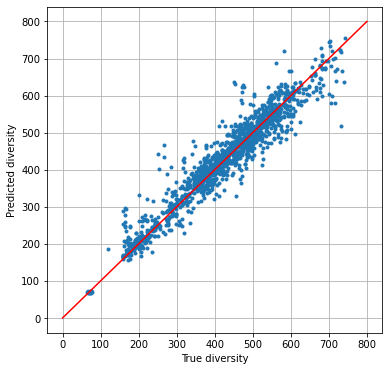

In [19]:
plot_true_vs_pred(test_labels*800,estimated_test_labels*800)

This is looking much better now. Compare this to our previous plot produced with the untrained model. You can see that during training the weights have been truly optimized towards the task of predicting species diversity, as almost all points are close to the center diagonal. We now have a model that can predict species diversity for any given point. This allows you for example to create continuous maps of species diversity, by defining a grid and predicting diversity for each grid cell. If you're interested you can check out [this preprint](https://doi.org/10.1101/2022.01.12.475997) to see what these predictions look like for a grid spanning the complete continent.

For a proper evaluation of the predictions, people usually report the mean absolute error (MAE),  mean absolute percentage error (MAPE), or mean squared error (MSE) (or some other equivalent). Let us calculate the **mean absolute percentage error (MAPE)** here, since it scales with the absolute values.

In [20]:
mape = np.mean(np.abs((estimated_test_labels.flatten() - test_labels.flatten())/test_labels.flatten()))
print('The mean absolute percentage error of the trained model is %.4f'%mape)

The mean absolute percentage error of the trained model is 0.0665


This means that on average our diversity predictions are off by around 6.7%.

### Uncertainty quantification using MC dropout
As we discussed in the lecture, the predictions made by regular NN models represent point estimates. While our prediction accuracy that we reached above is decent, this accuracy is based on a single estimate. Also, as it is right now, our model will predict diversity for any point, regardless whether the input feature data for that point are completely outside of the range of anything the model has ever been trained on. We want a way for our network to quantify how confident it is in its' predictions. This is where we can apply **MC dropout**.

First we need to redesing our NN model, adding dropout to our layers. You can put dropout on any layer you want, except for the output layer. Here I will add dropout to each of the two hidden layers. Here I'm using the dropout rates 0.2 and 0.1, telling the model to randomely drop 20% and 10% of the first and second layer, respectively.

In [21]:
architecture = []
# Input layer
architecture.append(tf.keras.layers.Flatten(input_shape=[train_features.shape[1]]))
# First hidden layer
architecture.append(tf.keras.layers.Dense(32, activation='relu'))
architecture.append(tf.keras.layers.Dropout(0.2))
#architecture.append(MCDropout(0.2))
# 2nd hidden layer
architecture.append(tf.keras.layers.Dense(8, activation='relu'))
architecture.append(tf.keras.layers.Dropout(0.1))
#architecture.append(MCDropout(0.1))
# Output layer
architecture.append(tf.keras.layers.Dense(1, activation='softplus'))  # sigmoid or tanh or softplus
# Compile the model
model = tf.keras.Sequential(architecture)
model.compile(loss='mae', optimizer='adam', metrics=['mae','mape','mse','msle'])
# Get overview of model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 26)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                864       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
____________________________________________________

______

**TASK:** Train the model with our training data in the same way as we did before for the regular model. Produce the training history plot that is shown below.

______

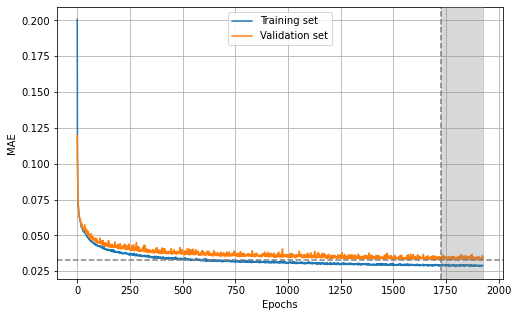

In [22]:
model_file = '/Users/tobiasandermann/Documents/teaching/ai_course_geosciences/biodiv_exercise/data/trained_model_dropout'
model = tf.keras.models.load_model(model_file)

plot_training_history(history)

As we talked about in the lecture, the training error (MAE) usually comes out higher than that of the validation set when using dropout. This is because the nodes are being dropped only for the training set predictions, but the validation set is unaffected by the specified dropout rates.

This time, when making predictions with our model, we will make them 100 times. You will see that each time the model predictions vary slightly, representing the uncertainty of the final model introduced by the dropped out nodes. To make sure that dropout is also applied to the predictions we have to use `model()` instead of `model.predict()` and set `training=True`.

In [23]:
mc_dropout_pred = np.stack([model(test_features,training=True) for i in np.arange(100)])
mc_dropout_mean = mc_dropout_pred.mean(axis=0)
mc_dropout_std = mc_dropout_pred.std(axis=0)

We will now plot these predictionsin the same way as before, but add the standard deviation of the predicted values for each test instance as an error bar, representing the uncertainty of the predictions.

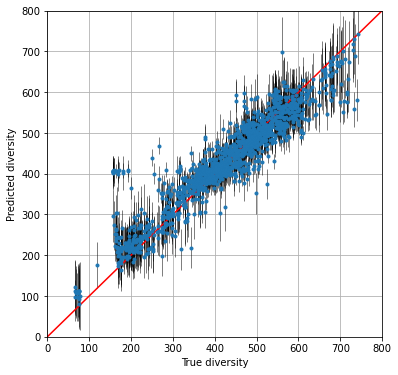

In [24]:
fig = plt.figure(figsize=(6, 6))
plt.errorbar(test_labels*800,mc_dropout_mean*800, yerr=mc_dropout_std.flatten()*800, fmt='.',alpha=1,ecolor='black',elinewidth=0.5)
plt.xlim(0,800)
plt.ylim(0,800)
plt.plot([0,800],[0,800],'r-')
plt.xlabel('True diversity')
plt.ylabel('Predicted diversity')
plt.grid()


You see that there is quite some uncertainty surrounding the predictions of some of the test instances, for some more than for others. The error bars seem to get larger towards very small or veyr large diversity instances.

_____

**TASK:** Try some different settings for the NN model. You can alter the number of layers, number of nodes per layer, dropout settings (if and where to place dropout layers, as well as altering the dropout fraction). You can also alter the input data and try different sets of features, e.g. only using the climatic features (columns `bio1`-`bio19`), or only using non-climatic features. What is the best MAPE score you can reach for the test set? My best attempt after model testing resulted in a MAPE score of 0.0609, if you can beat that I will buy you a coffee on the next occasion ;-)

______

### Dimensionality reduction
In this exercise we used 26 features, most of which (N=19) represent different climatic variables. These climatic variable from the [worldclim](https://www.worldclim.org) database are highly correlated with each other. Therefore it might be beneficial for our model to first reduce these to fewer, less correlated variables, before training the model. This can be done using methods of dimensionality reduction, such as UMAP. Let's try this on our data. For this we first need to identify and extract the biome features from our dataset.

In [25]:
biome_feature_ids = [i for i,feat_name in enumerate(feature_names) if 'bio_' in feat_name]
biome_features = rescaled_features[:,biome_feature_ids]

Now we need to install the UMAP Python library:
`pip install umap-learn`

In [26]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=250, min_dist=0)
umap_obj = reducer.fit(biome_features)
biome_features_transformed = reducer.transform(biome_features)


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Now that we only have two climate axes (rather than 19), we can actually plot the data in a 2D scatterplot. So each site in our input data now has 2 instead of 19 climatic variables. To get an idea of how informative these climate axes are in determining species diversity, we color the points based on the species diversity at the site.

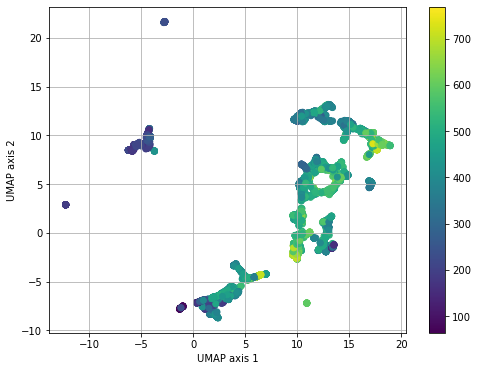

In [27]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(biome_features_transformed[:,0], biome_features_transformed[:,1], c=labels)
plt.colorbar()
plt.grid()
plt.xlabel('UMAP axis 1')
plt.ylabel('UMAP axis 2')
plt.show()

This is how you transform the data back to 19 dimensions. However, there will be some loss of information, i.e. the data won't look exactly as before, because they went through this information compression.

In [28]:
inv_transf = reducer.inverse_transform(biome_features_transformed)

We can compare the UMAP transformation to a regular principal component analysis (PCA), which is also a means of dimensionality reduction. The difference between UMAP and PCA is that the PCA assumes linear relationships between variables, while UMAP can represent non-linear relationships. Before you can run the PCA with the code below you will need to install the scikit-learn package: `pip install scikit-learn`.

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(biome_features)
biome_features_pca_transformed = pca.transform(biome_features)


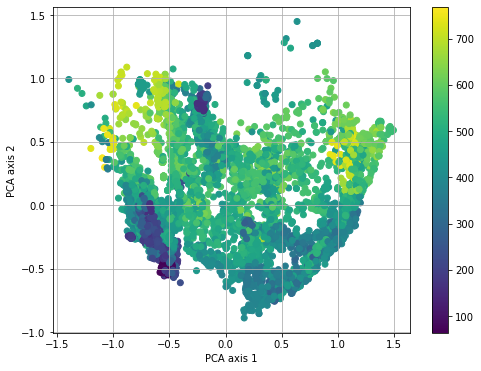

In [30]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(biome_features_pca_transformed[:,0], biome_features_pca_transformed[:,1], c=labels)
plt.colorbar()
plt.grid()
plt.xlabel('PCA axis 1')
plt.ylabel('PCA axis 2')
plt.show()

This is how you would transform the values back into 19 dimensions.

In [31]:
inv_transf_pca = pca.inverse_transform(biome_features_pca_transformed)


_____

**TASK:** Now run the NN training and prediction again (no dropout), but using the reduced feature set, i.e. the remaininig 7 non-climate features in combination with the 2-dimensional reduced climate features. Do this for both, the UMAP and PCA representation of the climate features, and compare the MAPE scores between the regular data (26 features), the UMAP data (7+2 features), and the PCA data (7+2 features). Did it help our model to reduce the dimensionalilty of the input data? Did one of the methods conserve the information content in the climatic features better than the other (compare MAPE between UMAP and PCA)?

The steps for this task are as follows:
1. Append 2 reduced climate features to remaining 7 non-climate features (using raw unscaled data). The code example below shows you how to do this.
2. Rescale feature array to values between 0 and 1
3. Separate data into training, validation, and test set
4. Define model architecture
5. Train model
6. Plot training history
7. Predict labels for test set
8. make scatterplot between true and estimated test set labels
9. Calculate MAPE score

_____

In [32]:
new_feature_data = np.hstack([features[:,:6],features[:,-1].reshape(len(features),1),biome_features_transformed])